In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#perc_axes = 0.07409181787428054


# 2. Set up grid

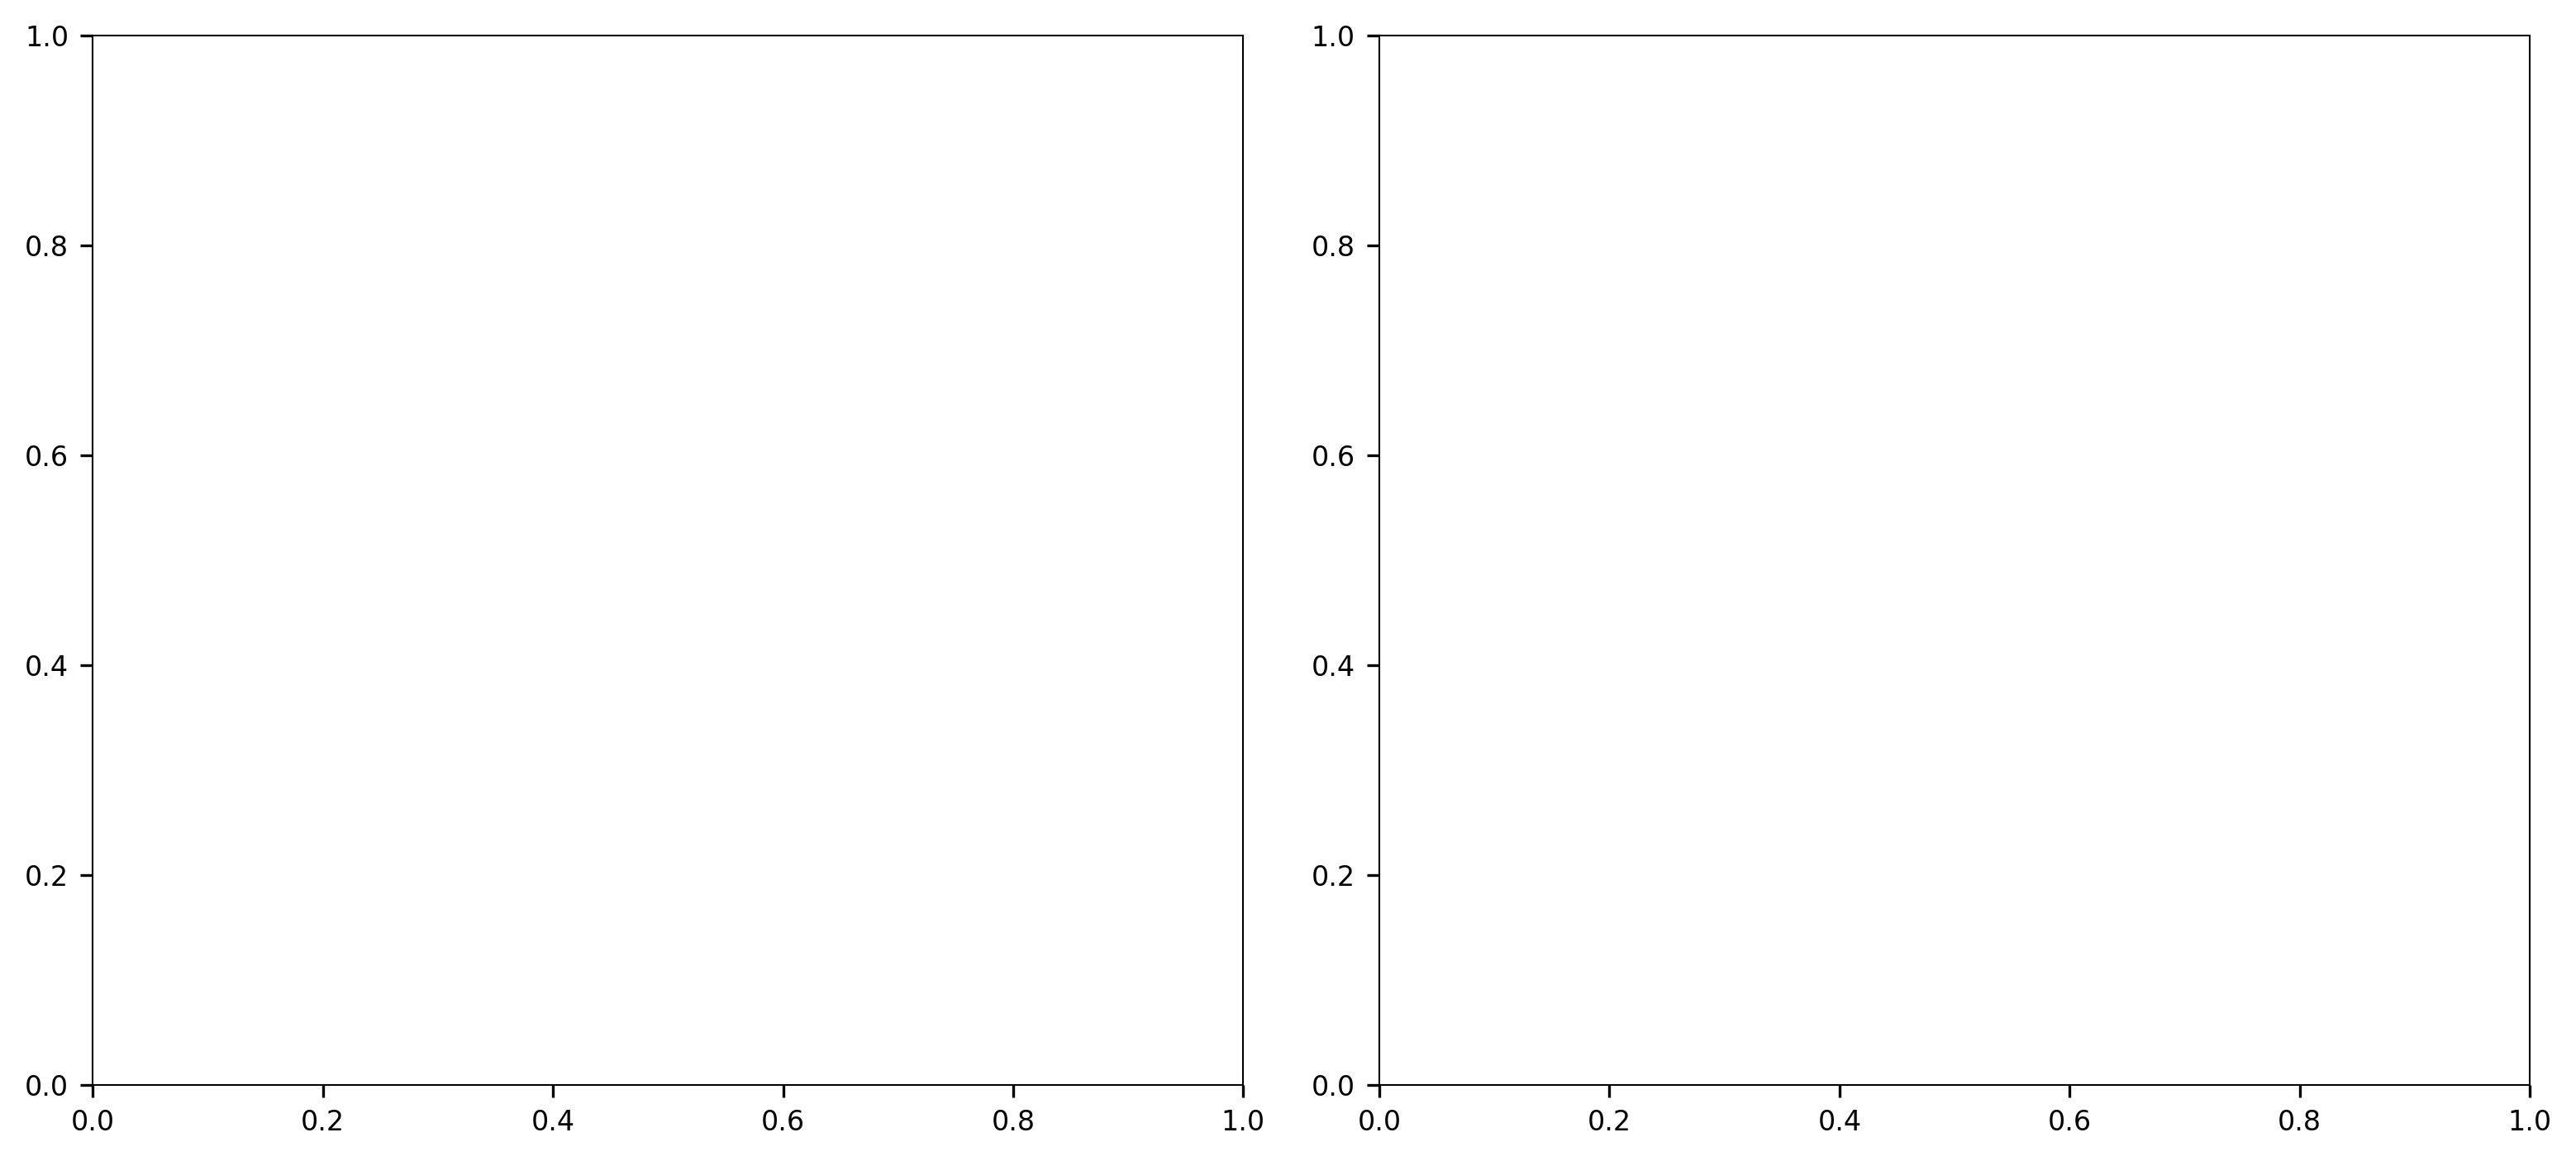

In [3]:
width = (174 / 25.4) * 1.5
height = 116 / 25.4 
sf2 = plt.figure(constrained_layout=True, figsize=(width, height))
gs = sf2.add_gridspec(1, 2)
ax1 = sf2.add_subplot(gs[0, 0])
ax2 = sf2.add_subplot(gs[0, 1])

#### Copied from fig2_v9

In [4]:
# Plot activity scores
point_muts = pd.read_csv('../utils/point_muts.csv', index_col=0, header=[0,1])
resids = pd.read_csv('../utils/residuals.csv', index_col=0)

point_muts.rename(index=dict(zip(point_muts.index.values, resids.index.values)), inplace=True)


# Remove variants not in library
samples = [
    'WT',
    'K298M',
    'Empty',
    'E381K',
    'W289H',
    'T293D',
    'G291L',
    'T443K',
    'F512A',
    'F512P',
    'E381S',
    'W285N',
    'E283V',
    'P302Y',
    'S333R'
    
]
samples_in_lib = samples.copy()
samples_in_lib[0] = '_wt'
samples_in_lib.remove('E381K')
samples_in_lib.remove('Empty')

# Pull out radicicol and DMSO activity scores for variants in scan and tested
point_muts_in_lib = point_muts.loc[samples_in_lib]
samples_in_lib_rad = point_muts_in_lib.loc[:, ('Radicicol', 'score')]
samples_in_lib_dmso = point_muts_in_lib.loc[:, ('Zero', 'score')]





# Get growth rates
filename = '../raw_data/20201031_cal_curve.summary'
growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)

wells_per_sample = 6

well_dict = {}
for idx, sample in enumerate(samples):
    
    # Get row number and convert to letter
    row_idx = idx % 8
    row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1
    
    # Determine if it's cols 1-6 or 7-12
    if idx / 8 >= 1.0:
        cols = np.arange(7, 13)
    else:
        cols = np.arange(1, 7)
    
    # Create dictionary where key=sample, value=wells
    well_dict[sample] = [row_char + str(col_idx) for col_idx in cols]
    
# Add sample_id and condition columns
growth_rates['sample_id'] = np.nan
growth_rates['condition'] = np.nan
for sample, wells in well_dict.items():
    dmso_wells = wells[:int(wells_per_sample / 2)]
    rad_wells = wells[int(wells_per_sample / 2):]
    growth_rates.loc[wells, 'sample_id'] = sample
    growth_rates.loc[dmso_wells, 'condition'] = 'DMSO'
    growth_rates.loc[rad_wells, 'condition'] = 'Radicicol'
    
growth_rates.dropna(inplace=True)





# Get average growth rates and stdv for all variants in scan and tested
dmso_rates = []
rad_rates = []

dmso_std = []
rad_std = []
for sample in samples:
    df_slice = growth_rates[growth_rates['sample_id'] == sample]
    dmso_slice = df_slice[df_slice['condition'] == 'DMSO']
    rad_slice = df_slice[df_slice['condition'] == 'Radicicol']

    dmso_rates.append(dmso_slice['Rate'].mean())
    rad_rates.append(rad_slice['Rate'].mean())
    
    dmso_std.append(dmso_slice['Rate'].std())
    rad_std.append(rad_slice['Rate'].std())
    
dmso_rates = np.array(dmso_rates)
rad_rates = np.array(rad_rates)
dmso_std = np.array(dmso_std)
rad_std = np.array(rad_std)

cal_curve_gr_df = pd.DataFrame(
    np.array((dmso_rates, rad_rates, dmso_std, rad_std)).T,
    index=samples,
    columns=['DMSO rate', 'Radicicol rate', 'DMSO std', 'Rad std']
)

In [5]:
# Get inhibited variant scores

samples2 = ['WT', 'K298M', 'Empty' ,'E381K' ,'E335M' ,'V274N', 'R294T', 'E381S', 'E283V']

filename2 = '../raw_data/20210426_ihb_fowler_biotek_formatted.summary'
growth_rates_ihb = pd.read_csv(filename2, index_col='Well', delimiter='\t', skiprows=1)


wells_per_sample = 6

well_dict2 = {}
for idx, sample in enumerate(samples2):
    
    # Get row number and convert to letter
    row_idx = idx % 8
    row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1
    
    # Determine if it's cols 1-6 or 7-12
    if idx / 8 >= 1.0:
        cols = np.arange(7, 13)
    else:
        cols = np.arange(1, 7)
    
    # Create dictionary where key=sample, value=wells
    well_dict2[sample] = [row_char + str(col_idx) for col_idx in cols]
    
# Add sample_id and condition columns
growth_rates_ihb['sample_id'] = np.nan
growth_rates_ihb['condition'] = np.nan
for sample, wells in well_dict2.items():
    dmso_wells = wells[:int(wells_per_sample / 2)]
    rad_wells = wells[int(wells_per_sample / 2):]
    growth_rates_ihb.loc[wells, 'sample_id'] = sample
    growth_rates_ihb.loc[dmso_wells, 'condition'] = 'DMSO'
    growth_rates_ihb.loc[rad_wells, 'condition'] = 'Radicicol'

growth_rates_ihb.dropna(inplace=True)

# Get average growth rates and stdv for all variants in scan and tested
dmso_rates_ihb = []
rad_rates_ihb = []

dmso_std_ihb = []
rad_std_ihb = []
for sample in samples2:
    if sample is '_wt':
        sample = 'WT'
    df_slice = growth_rates_ihb[growth_rates_ihb['sample_id'] == sample]
    dmso_slice = df_slice[df_slice['condition'] == 'DMSO']
    rad_slice = df_slice[df_slice['condition'] == 'Radicicol']

    dmso_rates_ihb.append(dmso_slice['Rate'].mean())
    rad_rates_ihb.append(rad_slice['Rate'].mean())
    
    dmso_std_ihb.append(dmso_slice['Rate'].std())
    rad_std_ihb.append(rad_slice['Rate'].std())
    
dmso_rates_ihb = np.array(dmso_rates_ihb)
rad_rates_ihb = np.array(rad_rates_ihb)
dmso_std_ihb = np.array(dmso_std_ihb)
rad_std_ihb = np.array(rad_std_ihb)

ihb_gr_df = pd.DataFrame(
    np.array((dmso_rates_ihb, rad_rates_ihb, dmso_std_ihb, rad_std_ihb)).T,
    index=samples2,
    columns=['DMSO rate', 'Radicicol rate', 'DMSO std', 'Rad std']
)

In [6]:
vars_to_plot = [
    'F512A', 'F512P', 'E381S',
    'E335M', 'V274N', 'R294T'
]

bar_pos = np.arange(len(vars_to_plot))
bar_width = 0.35

vars_to_plot_df = cal_curve_gr_df.loc[vars_to_plot[:-3]].append(ihb_gr_df.loc[vars_to_plot[-3:]])
ax1.bar(bar_pos - bar_width / 2, vars_to_plot_df['DMSO rate'], yerr=vars_to_plot_df['DMSO std'], width=bar_width, label='Basal', color='#b3b3b3')
ax1.bar(bar_pos + bar_width / 2, vars_to_plot_df['Radicicol rate'], yerr=vars_to_plot_df['Rad std'], width=bar_width, label='-Hsp90', color='#e26a6a')
ax1.legend()

x1, x2 = 0 - bar_width, 2 + bar_width   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.002, 0.000035, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, 'Negative client score', ha='center', va='bottom', color=col)

x1, x2 = 3 - bar_width, 5 + bar_width   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, 'Positive client score', ha='center', va='bottom', color=col)

ax1.set_ylim([0, 0.0025])
ax1.set_xticks(bar_pos)
ax1.set_xticklabels(vars_to_plot)
ax1.set_xlabel('Src Variants')
ax1.set_ylabel('Growth rate (OD600/min)')

Text(13.333333333333332, 0.5, 'Growth rate (OD600/min)')

# Showing inactive variants (maybe label the tested variants)

In [7]:
# Read in diffsel, dmso, and synon data

diffsel_df = pd.read_csv('../utils/diffsel_calib.csv', index_col=0)

dmso_df = pd.read_csv('../utils/point_muts_calib.csv', index_col=0, header=[0,1])
dmso_df.rename(dict(zip(dmso_df.index.tolist(), diffsel_df.index.tolist())), inplace=True)

synon_zero_df = pd.read_csv('../utils/synon_df.csv', index_col=0, header=[0,1])

synon_diffsel = np.genfromtxt('../utils/synon_diffsel_calib.txt', delimiter=',')

# Heatmap of diffsel values
diffsel_map = pd.read_csv('../utils/diffsel_calib_map.csv', index_col=0)


# Define cutoffs for GOF activity and strong client
dmso_cutoff = np.nanmean(synon_zero_df.values) + 1.3 * np.nanstd(synon_zero_df.values)
diffsel_cutoff = np.nanmean(synon_diffsel) - 2 * np.nanstd(synon_diffsel)

# Add positions column to diffsel_df
positions = [np.nan, np.nan]
for mut in diffsel_df.index.tolist()[2:]:
    position = int(mut[1:-1])
    positions.append(position)
diffsel_df['position'] = positions

In [8]:
pos_cutoff = np.nanmean(synon_diffsel) + 2 * np.nanstd(synon_diffsel)
pos_client_client_df = diffsel_df[diffsel_df['diffsel'] > pos_cutoff]


pos_clients = pos_client_client_df.index.tolist()
pos_client_activity_df = dmso_df.loc[pos_clients, ('Zero', 'score')]
lof_cutoff = np.nanmean(synon_zero_df.values) - 1.3 * np.nanstd(synon_zero_df.values)
lof_idx = pos_client_activity_df < lof_cutoff

vars_to_label = ['E335M' ,'V274N' ,'R294T']
x_arr = []
y_arr = []
for var in vars_to_label:
    x_arr.append(pos_client_client_df.loc[var, 'diffsel'])
    y_arr.append(pos_client_activity_df.loc[var])

ax2.scatter(pos_client_client_df['diffsel'], pos_client_activity_df, alpha=0.5, color='#b3b3b3')
for var, x, y in zip(vars_to_label, x_arr, y_arr):
    ax2.annotate(var, (x, y))
ax2.axhline(lof_cutoff, linestyle='--', c='k')
ax2.set_xlabel('Client score')
ax2.set_ylabel('Activity score')

Text(1570.0853018372704, 0.5, 'Activity score')

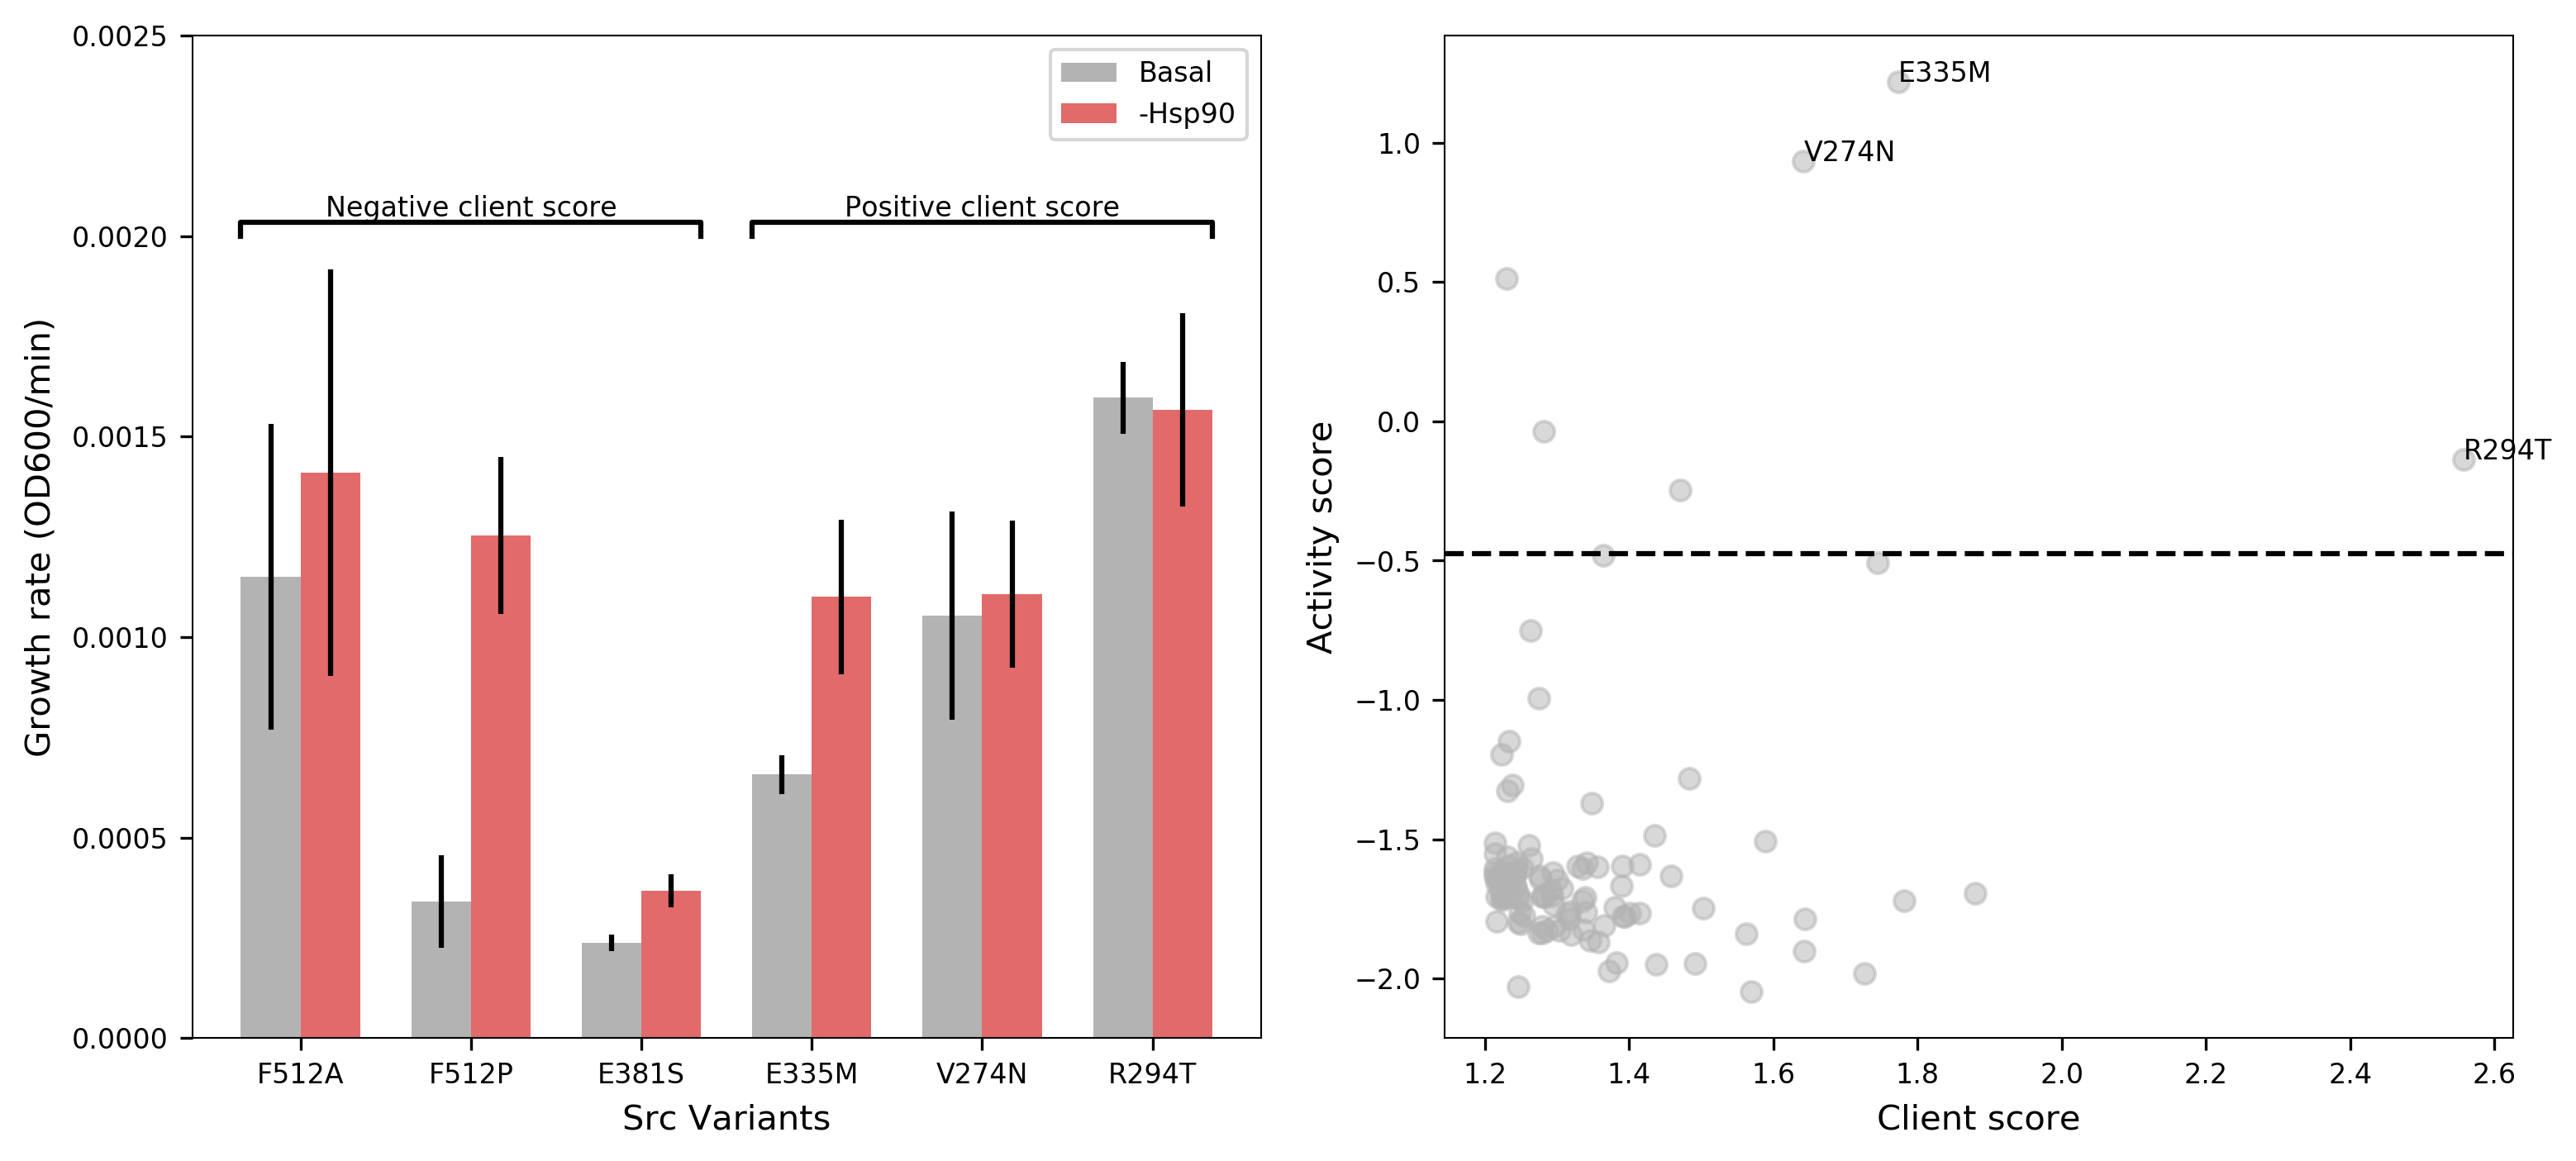

In [9]:
sf2

In [10]:
sf2.savefig('sf2.png')